# Imports

Import python libraries as well as the self written FERMI library.

In [ ]:
!pip install --user pyFAI

In [1]:
import sys, os
USER = os.environ['USER']

sys.path.append('./FERMI_2020-07/')
sys.path.append(f'/net/phase/store/users/{USER}/.local/lib/python3.9/site-packages')

import numpy as np
import xarray as xr
import pandas as pd
import h5py
from os.path import join, split
from glob import glob
from time import strftime
from imageio import imread

import pyFAI
pyFAI.disable_opencl=True # get rid of annoying warning ;)
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from pyFAI.detectors import Detector
from pyFAI.calibrant import Cell, Calibrant

from scipy.ndimage.filters import median_filter 


import matplotlib.pyplot as plt
from matplotlib.image import NonUniformImage
import process_FERMI_2021 as pf

from tqdm.auto import tqdm

from importlib import reload
from copy import deepcopy

In [2]:
#interactive plotting
%matplotlib widget

In [3]:
def plot_image(im, fname):
    fig, ax = plt.subplots(tight_layout=True)
    m = ax.imshow(im)
    plt.colorbar(m)
    ax.grid(False)
    fig.savefig(fname, dpi=100)
    plt.close(fig)

def plot_ai(df, time, samplefolder, scanfolder, fname):
    fig, ax = plt.subplots(tight_layout=True)
    az2d.plot.imshow(ax = ax, cmap = 'viridis')
    ax.set_title(f'{samplefolder} / {scanfolder}: delay %.2fps'%time)
    fig.savefig(fname, dpi=100)
    plt.close(fig)

def plot_curve(xdata, ydata, fname, xlabel = '', ylabel = ''):
    fig, ax = plt.subplots(tight_layout=True)
    ax.plot(xdata, ydata, 'o-')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.savefig(fname, dpi=100)
    plt.close(fig)

In [4]:
filters = {'Al-780 (3)': .34*.85,} #775nm of pure Al, 5nm of Al2O3

# Loading

## Load reference/dark images

In [5]:
#Setup
basefolder = f'/net/phase/store/users/{USER}/20209130/'
samplefolder = 'PtCoTa_76/'
scanfolder = 'B2_IntensityIR_Before'

In [8]:
#Get reference image (or dark image)
darkfolder = join(basefolder,samplefolder,scanfolder)
darks = []
dflist = glob(darkfolder + '/**/*h5', recursive=True)
print(f'found {len(dflist)} files')
#for f in dflist:
#    _dark = pf.loadh5(f)[0]
#    darks.append(_dark)
#dark = np.mean(darks, axis = 0).astype(float)

dark, dmeta = pf.loadh5(dflist[0], extra_keys={'diode_sum': 'PAM/FQPDSum',})
dark = dark/np.sum(dmeta['diode_sum'])

found 1 files


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
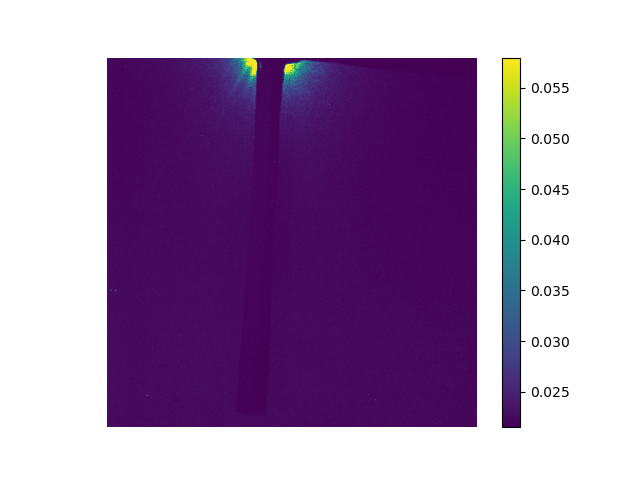

In [9]:
#Plot images
fig, ax = plt.subplots()
mi, ma = np.percentile(dark, (.1,99.9))
mm = ax.imshow(dark, vmin = mi, vmax = ma)
plt.colorbar(mm)
ax.set_axis_off()

## Setup masks

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
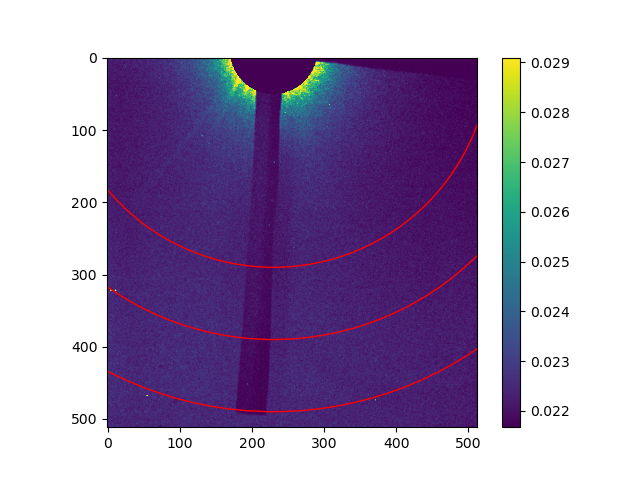

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
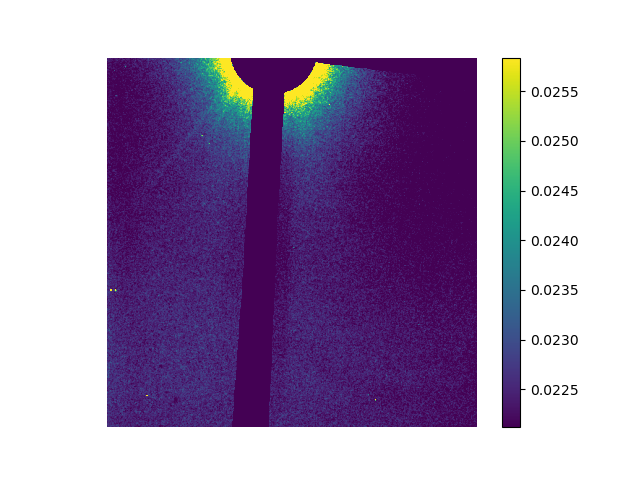

In [10]:
#Mask beamstop
mask_manual = imread('../masks/TaCoPt_bin4_mask.png')[..., 0]
mask_manual = mask_manual > 0
mask_manual = mask_manual.astype(int)

center = [-10, 230]  # off-set, binned
rmin = 60
beamstop = None
mask_0 = pf.make_mask(dark, center, rmin, beamstop=beamstop)

#complete mask
mask = mask_manual*mask_0

#Apply mask to images
dark_bs = dark*mask

#Plot images
fig, ax = plt.subplots()
mi, ma = np.percentile(dark_bs, (30,99))
mm = ax.imshow(dark_bs, vmin = mi, vmax = ma)
plt.colorbar(mm)
ax.set_axis_off()

In [135]:
#Define save folder
folder_save = f'/net/phase/store/users/{USER}/20209130/results/usr/ck/Laser_Fluence_Threshold/{samplefolder}'

if not(os.path.exists(folder_save)):
    print("Creating folder " + folder_save)
    os.mkdir(folder_save)
    
#Save real part of reco
plt.savefig(join(folder_save,scanfolder), bbox_inches='tight', transparent = True)    

## Load image (single)

In [16]:
#Get Scan Id
scanfolder = 'B2_0p00A_IntensityIR_30p1uJ'

In [21]:
#Get reference image (or dark image)
imfolder = join(basefolder,samplefolder,scanfolder)
images = []
imlist = glob(imfolder + '/**/*h5', recursive=True)
print(f'found {len(imlist)} files')
#for f in imlist:
#    _image = pf.loadh5(f)[0]
#    images.append(_image)
#im = np.mean(images, axis = 0).astype(float)

im, meta = pf.loadh5(imlist[0], extra_keys={'diode_sum': 'PAM/FQPDSum',})
im = im/np.sum(meta['diode_sum'])

found 1 files


In [18]:
#Subtract reference (dark) image
#im = im-dark

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
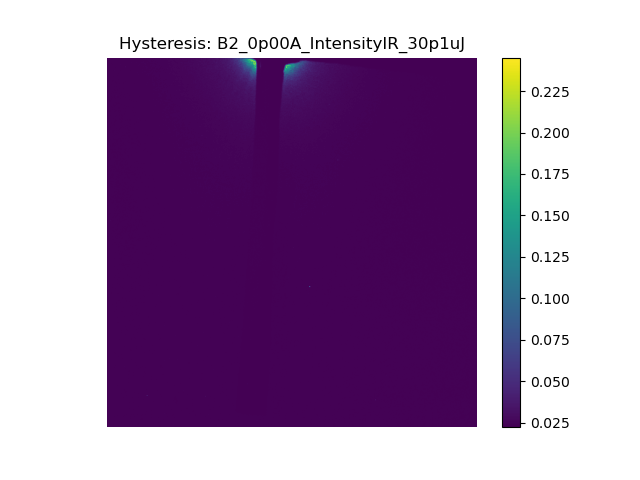

In [23]:
#Plot images
fig, ax = plt.subplots()
mi, ma = np.percentile(im, (.1,99.9))
mm = ax.imshow(im)#, vmin = mi, vmax = ma)
ax.set_axis_off()
plt.title(f'Hysteresis: {scanfolder}')
plt.colorbar(mm)

In [108]:
#Define save folder
folder_save = f'/net/phase/store/users/{USER}/20209130/results/usr/ck/Laser_Fluence_Threshold/{samplefolder}'

if not(os.path.exists(folder_save)):
    print("Creating folder " + folder_save)
    os.mkdir(folder_save)
    
#Save real part of reco
plt.savefig(join(folder_save,scanfolder), bbox_inches='tight', transparent = True)    

# Azimutal Integration for specific images

## Set up the azimuthal integration
This has to be done only once (unless the image center shifts, or the image shape changes).
Reusing the AzimuthalIntegrator instance is very fast.

You need to specifiy the center (determine it via the plotted image above). The rest is filled in automatically from the image shape and image meta data. 

In [513]:
datafolder = join(basefolder, samplefolder, scanfolder)
extra_keys = {
    'diode_sum': 'PAM/FQPDSum',
    'IR': 'Laser/Energy1',
    'magnet': 'Lecroy/Wave3',
    'bunches': 'bunches',
    'time': '',
}

exp = pf.get_exp_dataframe(datafolder, keys=extra_keys)
for k in ['xgm_UH', 'xgm_SH', 'diode_sum']:
    exp[k + '_sum'] = exp[k].apply(np.sum)

exp['diode_sum_mean'] = exp.diode_sum.apply(np.mean)
exp['diode_sum_std'] = exp.diode_sum.apply(np.std)
exp['IR_mean'] = exp.IR.apply(np.mean)
exp['IR_std'] = exp.IR.apply(np.std)
exp['bunchid'] = exp.bunches.apply(lambda l: l[-1])

exp = exp.sort_values('delay')

In [522]:
detector = Detector(2 * 13.5e-6, 2 * 13.5e-6)  # binned!
ai = AzimuthalIntegrator(dist=(exp['ccdz'][0] + 33) / 1000,
                         rot2=-np.deg2rad(exp['ccd_rot'][0]),
                         poni2=460 * 13.5e-6 * 2,
                         poni1=1230 * 13.5e-6 * 2,
                         detector=detector,
                         wavelength=exp['wavelength'][0] * 1e-9)

test it on our single image

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
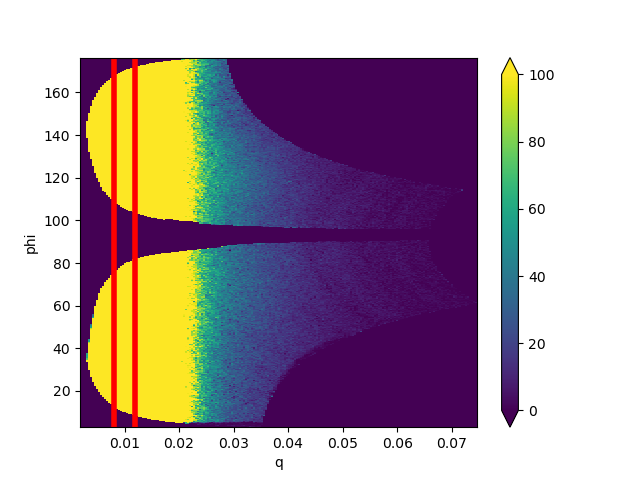

In [523]:
I_t, q_t, phi_t = ai.integrate2d(im, 200, unit='q_nm^-1', mask = 1-mask.astype(bool), correctSolidAngle=False)
az2d = xr.DataArray(I_t, dims = ('phi', 'q'), coords = {'q':q_t, 'phi': phi_t})
fig, ax = plt.subplots()
az2d.plot.imshow(ax = ax, vmin = 0, vmax = 100)
plt.axvline(x=0.008,linewidth=4, color='r')
plt.axvline(x=0.012,linewidth=4, color='r')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
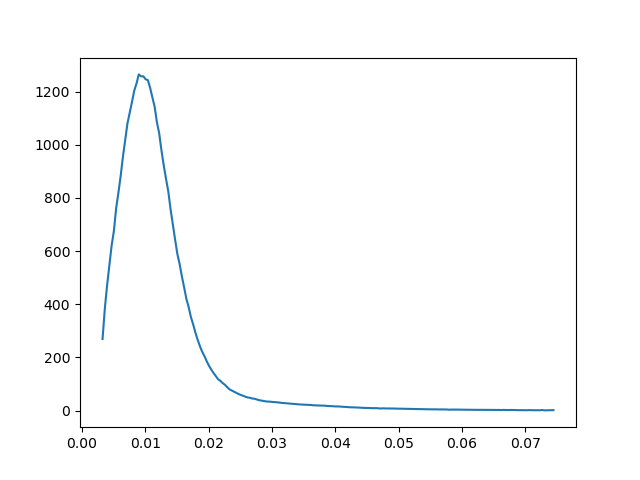

In [524]:
q, I = ai.integrate1d(im, 200, unit='q_nm^-1', mask = (1-mask).astype(bool), correctSolidAngle = False)
fig, ax = plt.subplots()
ax.plot(q, I)

# Next

In [528]:
#Get Image list
imagelist = [['I2_0p75A_IntensityIR_7p5uJ', 7.5],
    ['I2_0p75A_IntensityIR_10p0uJ',10.0],
    ['I2_0p75A_IntensityIR_10p5uJ',10.5],
    ['I2_0p75A_IntensityIR_11p0uJ',11.0],
    ['I2_0p75A_IntensityIR_12p0uJ',12.0],
    ['I2_0p75A_IntensityIR_12p6uJ',12.6],
    ['I2_0p75A_IntensityIR_15p0uJ',15.0],
    ['I2_0p75A_IntensityIR_17p5uJ',17.5],
    ['I2_0p75A_IntensityIR_20p0uJ',20.0]]
             
df = pd.DataFrame(imagelist, columns = ['fname', 'IR'])

In [529]:
az_int = []
for f in df['fname']:
    imfolder = join(basefolder,samplefolder,f)
    tlist = glob(imfolder + '/**/*h5', recursive=True)
    im, meta = pf.loadh5(tlist[0], extra_keys={'diode_sum': 'PAM/FQPDSum',})
    
    im = im/ np.sum(meta['diode_sum'])
    q, I = ai.integrate1d(im, 200, unit='q_nm^-1', mask = (1-mask).astype(bool), correctSolidAngle = False)
    az_int.append(I)
#integrated = xr.DataArray(az_int, dims=['labels', 'q'], coords = {'q': q})
az_int = np.array(az_int)

Text(0, 0.5, 'intensity')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
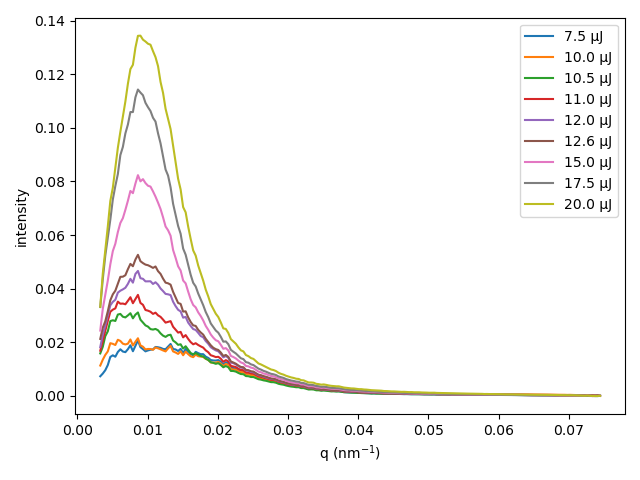

In [532]:
fig, ax = plt.subplots(tight_layout = True)
for i in range(az_int.shape[0]):
    ax.plot(q, az_int[i]-az_int[i][-1], label = '%0.1f µJ'%df['IR'][i])
ax.legend()
ax.set_xlabel('q (nm$^{-1}$)')
ax.set_ylabel('intensity')
#ax.grid()
#ax.set_title(f'{samplefolder} / {scanfolder}: Magnet %.1f A'%mag_max)

In [251]:
#Get reference image (or dark image)
imfolder = join(basefolder,samplefolder,scanfolder)
tlist = glob(imfolder + '/**/*h5', recursive=True)
tim = pf.loadh5(tlist[0])[0]
#    images.append(_image)
#im = np.mean(images, axis = 0).astype(float)

In [247]:
az_int = []
for f in sortf:
    im, meta = pf.loadh5(f, extra_keys={'diode_sum': 'PAM/FQPDSum',})
    im = (im - dark.astype(float))/ np.sum(meta['diode_sum'])
    im -= (np.mean(im[-50:, 500:]) + before)
    images.append(im)
    q, I = ai.integrate1d(im * mask, 200, unit='q_nm^-1')
    az_int.append(I / norm)
integrated = xr.DataArray(az_int, dims=['labels', 'q'], coords = {'q': q})
images = np.array(images)

array([[1185, 1228, 1277, ..., 1088, 1088, 1090],
       [1210, 1238, 1320, ..., 1091, 1094, 1088],
       [1213, 1241, 1343, ..., 1100, 1103, 1099],
       ...,
       [1112, 1094, 1092, ..., 1100, 1105, 1093],
       [1094, 1104, 1105, ..., 1089, 1100, 1104],
       [1104, 1105, 1107, ..., 1095, 1095, 1096]], dtype=uint16)

In [ ]:
#Get reference image (or dark image)
imfolder = join(basefolder,samplefolder,scanfolder)
images = []
imlist = glob(imfolder + '/**/*h5', recursive=True)
print(f'found {len(imlist)} files')
for f in imlist:
    _image = pf.loadh5(f)[0]
    images.append(_image)
im = np.mean(images, axis = 0).astype(float)

In [210]:
filtered = pf.filtering(f'{basefolder}{samplefolder}/', list(k for k in imagelist.keys()))
filtered = [f for f in filtered if 'C4' in f]

,0,1,2,3,4,5,6,7,8
fname,I2_0p75A_IntensityIR_7p5uJ,I2_0p75A_IntensityIR_10p0uJ,I2_0p75A_IntensityIR_10p5uJ,I2_0p75A_IntensityIR_11p0uJ,I2_0p75A_IntensityIR_12p0uJ,I2_0p75A_IntensityIR_12p6uJ,I2_0p75A_IntensityIR_15p0uJ,I2_0p75A_IntensityIR_17p5uJ,I2_0p75A_IntensityIR_20p0uJ
IR,7.5,10.0,10.5,11.0,12.0,12.6,15.0,17.5,20.0


In [211]:
print(filtered)

KeyError: 'fname'

In [ ]:
sortf = np.array([filtered[0]] * len(filtered))
imarray = np.array(list(k for k in imagelist.keys()))
for file in filtered:
    idx = np.where(imarray == file[-7:])[0][0]
    sortf[idx] = deepcopy(file)

## Integrate in q

In [ ]:
az_int = []
images = []
for f in sortf:
    im, meta = pf.loadh5(f, extra_keys={'diode_sum': 'PAM/FQPDSum',})
    im = (im - dark.astype(float))/ np.sum(meta['diode_sum'])
    im -= (np.mean(im[-50:, 500:]) + before)
    images.append(im)
    q, I = ai.integrate1d(im * mask, 200, unit='q_nm^-1')
    az_int.append()
integrated = xr.DataArray(az_int, dims=['labels', 'q'], coords = {'q': q})
images = np.array(images)

In [ ]:
integrated[-2].to_netcdf(f'/home/gerlinger/Documents/Beamtimes/2020-06_FERMI/Processed/{samplefolder}/{scanfolder}/{scanfolder}_final-state.h5')
I_fel = integrated[-2]

In [ ]:
label = np.round(np.array([ 2.08208978,  4.16417957,  6.24626935,  8.32835914, 10.41044892, 12.4925387 , 14.57462849, 16.65671827]), decimals = 1)
blues = ['#edf8b1', '#c7e9b4', '#7fcdbb', '#41b6c4', '#1d91c0', '#225ea8', '#253494', '#081d58']
# plot, instead of the file endings you can also define a label list and iterate through that list
fig, ax = plt.subplots()
ct = 0
for data in integrated:
    ax.plot(integrated.q, data, blues[ct], label = f'{label[ct]} mJ/cm$^2$')
    ct += 1
plt.legend()
ax.set_xlabel('q (nm$^{-1}$)')
ax.set_ylabel('intensity (a.u.)')
ax.grid()
ax.set_title(f'{samplefolder} / {scanfolder}: Magnet %.1f A'%mag_max)
fig.tight_layout()